In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1
!pip -qq install spacy==2.0.16
!python -m spacy download en
!pip install sacremoses==0.0.5
!!pip install subword_nmt==0.3.5
!wget -qq http://www.manythings.org/anki/rus-eng.zip 
!unzip rus-eng.zip

tcmalloc: large alloc 1073750016 bytes == 0x58eba000 @  0x7fc1574172a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 37.4MB 1.5MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |████████████████████████████████| 112kB 2.7MB/s 
  Running setup.py bdist_wheel for sacremoses ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fb/b4/f5/8ca724b21fc983eee2c9b99a7db69f85480c330a5bf6d8d546
Successfully built sacremoses
Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _ab

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Machine Translation

Мы уже несколько раз смотрели на эту картинку:

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg =x250)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

В POS tagging мы (ну, некоторые точно) использовали важную идею: сначала некоторой функцией над символами строился эмбеддинг для слова (например, many to one rnn'кой на картинке). Потом другая rnn'ка строила эмбеддинги слов с учетом их контекста. А дальше это всё классифицируется логистической регрессией.

Тут важно то, что мы обучаем encoder для построения эмбеддингов end2end - прямо в составе сети (это основное отличие нейросетей от классических подходов - в умении делать end2end).

Другое, что мы делали - это языковые модели. Вот, типа такого:
![](https://hsto.org/web/dc1/7c2/c4e/dc17c2c4e9ac434eb5346ada2c412c9a.png =x200)

Обратите внимание на красную стрелку - она показывает передачу скрытого состояния, которое отвечает за память сети.

А теперь совместим эти две идеи:

![](https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

Выглядит все почти как языковая модель, но в синей части предсказания не делаются, используется только последнее скрытое состояние.

Синяя часть сети называется энкодер, она строит эмбеддинг последовательности. Красная часть - декодер, работает как обычная языковая модель, но учитывает результат работы энкодера.

В итоге, энкодер учится эффективно извлекать смысл из последовательности слов, а декодер должен строить по ним новую последовательность. Это может быть последовательностью слов перевода, или последовательностью слов в ответе чат бота, или еще чем-то в зависимости от вашей испорченности.

## Подготовка данных

Начнем с чтения данных. Возьмем их у anki, поэтому они немного специфичны:

In [0]:
!shuf -n 10 rus.txt

Is there anything else you would like to eat?	Есть что-нибудь ещё, что вам хотелось бы отведать?
I think you should grow a beard.	Я думаю, тебе стоит отпустить бороду.
Could I borrow a pen?	Могу я одолжить ручку?
Excess of politeness is annoying.	Чрезмерная вежливость раздражает.
Are you Tom's brother?	Вы брат Тома?
It's a very dangerous sport, where a slight mistake can lead to serious injury.	Это очень опасный вид спорта, в котором даже небольшая ошибка может привести к серьёзным травмам.
It's time to take your medicine.	Тебе пора принимать лекарство.
I didn't want to kill Tom.	Я не хотела убивать Тома.
One acquires bad habits very easily.	Вредные привычки быстро перенимаются.
Look alive.	Поторапливайтесь.


Токенизируем их:

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]

In [0]:
source_field.preprocess("It's surprising that you haven't heard anything about her wedding.")

['It',
 "'s",
 'surprising',
 'that',
 'you',
 'have',
 "n't",
 'heard',
 'anything',
 'about',
 'her',
 'wedding',
 '.']

In [0]:
target_field.preprocess('Удивительно, что ты ничего не слышал о её свадьбе.')

['Удивительно',
 ',',
 'что',
 'ты',
 'ничего',
 'не',
 'слышал',
 'о',
 'её',
 'свадьбе',
 '.']

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [00:52<00:00, 6211.77it/s]


Построим датасеты:

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 83261
Test size = 14693
Source vocab size = 5231
Target vocab size = 10471


In [0]:
source_field.process([source_field.preprocess("It's surprising that you haven't heard anything about her wedding.")])

tensor([[  43],
        [  15],
        [5123],
        [  14],
        [   6],
        [  22],
        [   9],
        [ 248],
        [ 132],
        [  55],
        [  96],
        [1021],
        [   3],
        [   2]])

## Seq2seq модель

Пора писать простой seq2seq. Разобьем модель на несколько модулей - Encoder, Decoder и их объединение. 

Encoder должен быть подобен символьной сеточке в POS tagging'е: эмбеддить токены и запускать rnn'ку (в данном случае будем пользоваться GRU) и отдавать последнее скрытое состояние.

Decoder почти такой же, только еще и предсказывает токены на каждом своем шаге.

**Задание** Реализовать модели.

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        outputs = self._emb(inputs)
        outputs, hn = self._rnn(outputs)  # (seq_len, batch_size, rnn_hidden_dim), (1, batch_size, rnn_hidden_dim)
        return hn

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, scheduled=False ):
        super().__init__()
        self.scheduled = scheduled
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, hidden=None):
        embs = self._emb(inputs)
#         if self.scheduled:
#             outputs = []
#             step = None
#             for i in range(embs.shape[0]):            
#                 if i == 0 or np.random.rand() < 0.5:
#                     cur_input = embs[i:i+1]
#                 else:
#                     cur_input = outputs[-1].argmax(-1).detach()
#                     print("Prev output as input", cur_input.shape)
#                 print(cur_input.shape)
#                 step, hidden = self._rnn(cur_input, hidden)  # (1, batch_size, lstm_hidden_dim), (1, batch_size, lstm_hidden_dim)
#                 print("Rnn ouput", step.shape)
#                 step = self._out(step)  # (1, batch_size, vocab_size)
#                 outputs.append(step)
#             outputs = torch.cat(outputs)
#         else:
        outputs, hidden = self._rnn(embs, encoder_output)      
        outputs = self._out(outputs)
        return outputs, hidden

Модель перевода будет просто сперва вызывать Encoder, а потом передавать его скрытое состояние декодеру в качестве начального.

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=128, num_layers=1, bidirectional_encoder=False, scheduled=False):
        
        super().__init__()
        self.scheduled = scheduled
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers, scheduled=scheduled)
        
    def forward(self, source_inputs, target_inputs):
        encoder_hidden = self.encoder(source_inputs)
        if not self.scheduled or not self.training:
            return self.decoder(target_inputs, encoder_hidden)
        else:
            result = []
            hidden = encoder_hidden
            for i, target_input in enumerate(target_inputs):
                if i == 0 or np.random.rand() < 0.5:
                    step = target_input
                    step = step.view(1, step.shape[0])
                step, hidden = model.decoder(step, hidden)
                result.append(step)
                step = step.argmax(-1)
            return torch.cat(result), hidden


Реализуем простой перевод - жадный. На каждом шаге будем выдавать самый вероятный из предсказываемых токенов:

![](https://github.com/tensorflow/nmt/raw/master/nmt/g3doc/img/greedy_dec.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

**Задание** Реализовать функцию.

In [0]:
def greedy_decode(model, source_text, source_field, target_field):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        result = []
        inputs = source_field.process([source_field.preprocess(source_text)]).cuda()
        enc_hidden = model.encoder(inputs)
        step = torch.cuda.LongTensor([[bos_index]])
        
        for _ in range(30):
            step, hidden = model.decoder(step, enc_hidden)
            step = step.argmax(-1)
            result.append(step)
            
            if step.squeeze().item() == eos_index:
                break
        
            
        return ' '.join(target_field.vocab.itos[ind.squeeze().item()] for ind in result)

In [0]:
greedy_decode(model, "Do you believe?", source_field, target_field)

'Ты веришь в <unk> ?'

Нужно как-то оценивать модель.

Обычно для этого используется [BLEU скор](https://en.wikipedia.org/wiki/BLEU) - что-то вроде точности угадывания n-gram из правильного (референсного) перевода.

**Задание** Реализовать функцию оценки: для батчей из `iterator` предсказать их переводы, обрезать по `</s>` и сложить правильные варианты и предсказанные в `refs` и `hyps` соответственно.

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, iterator):
    model.eval()
    refs, hyps = [], []
    bos_index = iterator.dataset.fields['target'].vocab.stoi[BOS_TOKEN]
    eos_index = iterator.dataset.fields['target'].vocab.stoi[EOS_TOKEN]
    with torch.no_grad():
        for i, batch in enumerate(iterator): 
            
            targets = batch.target.data.cpu().numpy().T
            _, eos_indices = np.where(targets == eos_index)
            _, bos_indices = np.where(targets == bos_index)
            targets = [target[bos_idx + 1:eos_idx] for bos_idx, eos_idx, target in zip(bos_indices, eos_indices, targets)]
            refs.extend(targets)
                   
            result = []

            enc_hidden = model.encoder(batch.source)
            hidden = enc_hidden
            step = LongTensor([bos_index]).expand(1, batch.target.shape[1])
            for _ in range(30):
                step, hidden = model.decoder(step, hidden)
                step = step.argmax(-1)
                result.append(step)
            result = torch.cat(result)
            result = result.data.cpu().numpy().T
            eos_indices = []
            for res in result:
                if eos_index in res:
                    eos_indices.append(np.where(res == eos_index)[0][0])
                else:
                    eos_indices.append(res.shape[0])
            result = [res[:eos_idx] for eos_idx, res in zip(eos_indices, result)]
            hyps.extend(result)
            
    return corpus_bleu([[ref] for ref in refs], hyps) * 100

In [0]:
evaluate_model(model, test_iter)

0.8175169897702937

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.source, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=11, val_iter=test_iter)

[2 / 11] Train: Loss = 2.88400, PPX = 17.89:   0%|          | 3/2602 [00:00<06:13,  6.96it/s]


Val BLEU = 10.71


[3 / 11] Train: Loss = 2.39388, PPX = 10.96:   0%|          | 3/2602 [00:00<06:02,  7.17it/s]


Val BLEU = 13.33


[4 / 11] Train: Loss = 2.34627, PPX = 10.45:   0%|          | 2/2602 [00:00<06:26,  6.72it/s]


Val BLEU = 15.37


[5 / 11] Train: Loss = 2.07606, PPX = 7.97:   0%|          | 3/2602 [00:00<06:08,  7.06it/s]


Val BLEU = 16.94


[6 / 11] Train: Loss = 1.35919, PPX = 3.89:   0%|          | 3/2602 [00:00<06:12,  6.98it/s]


Val BLEU = 18.03


[7 / 11] Train: Loss = 1.18306, PPX = 3.26:   0%|          | 3/2602 [00:00<06:17,  6.88it/s]


Val BLEU = 18.76


[8 / 11] Train: Loss = 1.27352, PPX = 3.57:   0%|          | 3/2602 [00:00<06:17,  6.89it/s]


Val BLEU = 19.50


[9 / 11] Train: Loss = 1.27432, PPX = 3.58:   0%|          | 3/2602 [00:00<06:14,  6.93it/s]


Val BLEU = 20.08


[10 / 11] Train: Loss = 1.01304, PPX = 2.75:   0%|          | 3/2602 [00:00<06:10,  7.01it/s]


Val BLEU = 20.61


[11 / 11] Train: Loss = 0.79776, PPX = 2.22:   0%|          | 2/2602 [00:00<06:47,  6.37it/s]


Val BLEU = 20.87


[11 / 11]   Val: Loss = 1.95952, PPX = 7.10: 100%|██████████| 58/58 [00:01<00:00, 34.29it/s]



Val BLEU = 21.07


## Scheduled sampling

До сих пор мы тренировали перевод, используя так называемый *teacher forcing*: в качестве выхода на предыдущем шаге декодер принимал всегда правильный токен. Проблема такого подхода - во время инференса правильный токен, скорее всего, не выберется хотя бы на каком-то шаге. Получится, что сеть училась на хороших входах, использоваться будет на плохом - это легко может всё поломать.

Альтернативный подход - прямо во время обучения сэмплировать токен с текущего шага и передавать его на следующий.

Такой подход не слишком-то обоснован математически (градиенты не прокидываются через сэмплирование), но его интересно реализовать и он зачастую улучшает качество.

**Задание** Обновите `Decoder`: замените вызов rnn'ки над последовательностью на цикл. На каждом шаге вероятностью `p` передавайте в качестве предыдущего выхода декодеру правильный вход, а иначе - argmax от предыдущего выхода (цикл должен быть похожим на те, которые есть в `greedy_decode` и `evaluate_model`). При передаче argmax вызывайте `detach`, чтобы градиенты не прокидывались. Все выходы собирайте в список, в конце сделайте `torch.cat`. 

В результате при вероятности, равной `p=1`, должно получиться как раньше, только медленнее. При обучении можно передавать `p=0.5`, на инференсе - `p=1`.

In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab), scheduled=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.49


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.67


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.76


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.74


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.77


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.77


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.82


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.80


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.81


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.81


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.78


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.78


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.78


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.77


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.75


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.73


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.75


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 0.76


[19 / 30] Train: Loss = 1.68953, PPX = 5.42:  66%|██████▌   | 1714/2602 [01:54<00:59, 14.91it/s]


KeyboardInterrupt: ignored

In [0]:
greedy_decode(model, "Do you believe?", source_field, target_field)  # scheduled

'Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете , Вы считаете ,'

In [0]:
evaluate_model(model, test_iter)  # scheduled

0.6961943466499939

## Beam Search

Другой способ бороться с ошибками в декодировании на инференсе - делать beam search. По сути это поиск в глубину с очень сильными отсечениями на каждом шаге:

![](https://image.ibb.co/dBRKkA/2018-11-06-13-53-40.png =x300)   
*From [cs224n, Machine Translation, Seq2Seq and Attention](http://web.stanford.edu/class/cs224n/lectures/lecture10.pdf)*

На картинке на каждом шаге выбирается два лучших (согласно предсказаниям сети) из четырех вариантов продолжений цепочек.

Для сравнения бимов используются суммы log-вероятностей токенов, входящих в бим. Чтобы получить log-вероятности, нужно просто вызвать `F.log_softmax` у логитов. Преимущество сложения логарифмов перед умножением вероятностей должно быть понятно: нет таких проблем с численной неустойчивостью - умножая вероятности, близкие к нулю, мы очень шустро получим ноль в качестве скора бима.

В итоге нужно реализовать аналог `gready_decoding`. 

Beam будет состоять из последовательности индексов токенов (в начале - `[bos_index]`),  суммарного качества (в начале 0) и последнего `hidden` (в начале `encoder_hidden`).


Интерактивная визуализация, утащенная у https://github.com/yandexdataschool/nlp_course:

In [0]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/beam_search.html 2> log
from IPython.display import HTML
# source: parlament does not support the amendment freeing tymoshenko
HTML('./beam_search.html')

In [0]:
def beam_search_decode(model, source_text, source_field, target_field, beam_size=5):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        encoder_hidden = model.encoder(source_field.process([source_field.preprocess(source_text)]).cuda())
        beams = [([bos_index], 0, encoder_hidden)]  # tokens, score summary, hidden
        
        ready_beams = []
        for _ in range(30):
            beams_continuations = []

            # 1. make next step from each beam
            for beam in beams:
                tokens, score, hidden = beam
                inputs = LongTensor([[tokens[-1]]])
                output, hidden = model.decoder(inputs, hidden)
                maxs, argmaxs = output.sort(-1, descending=True)

                for i in range(2):
                    token = argmaxs.view(-1, argmaxs.shape[-1])[:, i]
                    prob = maxs.view(-1, maxs.shape[-1])[:, i]
                    token, prob = token.view(argmaxs.shape[:-1], 1), prob.view(maxs.shape[:-1], 1)
                    score += F.log_softmax(prob)
                    beams_continuations.append( (tokens + [token], score, hidden) )

            # 2. create new beams from top beam_size of each continuation (best next token variants for the given token)
            beams = beams_continuations

            # 3. leave only top beam_size beams
            beams = sorted( beams, key=lambda beam: -beam[1] / len(beam[0]) )[:beam_size]
            # 4. repeat
            for beam in beams:
                if beam[0][-1] == eos_index:
                    ready_beams.append(beam)
            if len(ready_beams) >= len(beams):
                break
                
        beams += ready_beams
        
        result = max( beams, key=lambda beam: -beam[1] / len(beam[0]) )[0]
        return ' '.join(target_field.vocab.itos[ind] for ind in result)

In [0]:
beam_search_decode(model, "Do you believe?", source_field, target_field)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'<s> Ты веришь ? </s> ? </s> ? </s>'

## Улучшения модели

**Задание** Попробуйте повысить качество модели. Попробуйте: 
- Bidirectional encoder
- Dropout
- Stack moar layers

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()
        
        self.bidirectional = bidirectional

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.Sequential(
            nn.Dropout(0.3),
            nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)
        )

    def forward(self, inputs, hidden=None):
        outputs = self._emb(inputs)
        outputs, hn = self._rnn(outputs)
        if self.bidirectional:
            hn = torch.cat((hn[0], hn[1]), dim=-1).unsqueeze(0)
        return hn
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, scheduled=False ):
        super().__init__()
        self.scheduled = scheduled
        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, emb_dim),
            nn.Dropout(0.3)
        )
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out =  nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(rnn_hidden_dim, vocab_size)
        )

    def forward(self, inputs, encoder_output):
        embs = self._emb(inputs)
        outputs, hidden = self._rnn(embs, encoder_output)      
        outputs = self._out(outputs)
        return outputs, hidden
    
class ImprovedTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=128, num_layers=1, bidirectional_encoder=False, scheduled=False):
        
        super().__init__()
        self.scheduled = scheduled
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim * (2 if bidirectional_encoder else 1), \
                               num_layers, scheduled=scheduled)
        
    def forward(self, source_inputs, target_inputs):
        encoder_hidden = self.encoder(source_inputs)
        
        if not self.scheduled or not self.training:
            return self.decoder(target_inputs, encoder_hidden)
        else:
            result = []
            hidden = encoder_hidden
            for i, target_input in enumerate(target_inputs):
                if i == 0 or np.random.rand() < 0.5:
                    step = target_input
                    step = step.view(1, step.shape[0])
                step, hidden = model.decoder(step, hidden)
                result.append(step)
                step = step.argmax(-1)
            return torch.cat(result), hidden

        from nltk.translate.bleu_score import corpus_bleu


In [0]:
model = ImprovedTranslationModel(source_vocab_size=len(source_field.vocab), \
             target_vocab_size=len(target_field.vocab), scheduled=True, bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

[2 / 30] Train: Loss = 3.14795, PPX = 23.29:   0%|          | 1/2602 [00:00<08:02,  5.39it/s]


Val BLEU = 12.56


[3 / 30] Train: Loss = 2.55656, PPX = 12.89:   0%|          | 1/2602 [00:00<08:15,  5.25it/s]


Val BLEU = 16.29


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 19.59


[5 / 30] Train: Loss = 2.44425, PPX = 11.52:   0%|          | 1/2602 [00:00<08:09,  5.31it/s]


Val BLEU = 21.24


[6 / 30] Train: Loss = 1.88694, PPX = 6.60:   0%|          | 1/2602 [00:00<08:19,  5.21it/s]


Val BLEU = 22.41


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 23.68


[8 / 30] Train: Loss = 1.84976, PPX = 6.36:   0%|          | 1/2602 [00:00<08:07,  5.33it/s]


Val BLEU = 24.83


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 25.55


  0%|          | 1/2602 [00:00<08:31,  5.08it/s]


Val BLEU = 25.91


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 26.55


[12 / 30] Train: Loss = 2.08635, PPX = 8.06:   0%|          | 1/2602 [00:00<08:15,  5.25it/s]


Val BLEU = 27.17


[13 / 30] Train: Loss = 1.60775, PPX = 4.99:   0%|          | 1/2602 [00:00<08:19,  5.21it/s]


Val BLEU = 27.57


[14 / 30] Train: Loss = 1.37582, PPX = 3.96:   0%|          | 1/2602 [00:00<08:00,  5.41it/s]


Val BLEU = 28.09


  0%|          | 1/2602 [00:00<08:26,  5.14it/s]


Val BLEU = 28.13


  0%|          | 1/2602 [00:00<08:27,  5.12it/s]


Val BLEU = 28.69


[17 / 30] Train: Loss = 1.50712, PPX = 4.51:   0%|          | 1/2602 [00:00<08:18,  5.22it/s]


Val BLEU = 28.90


[18 / 30] Train: Loss = 1.57117, PPX = 4.81:   0%|          | 1/2602 [00:00<08:17,  5.22it/s]


Val BLEU = 28.94


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.24


[20 / 30] Train: Loss = 1.55325, PPX = 4.73:   0%|          | 1/2602 [00:00<08:16,  5.24it/s]


Val BLEU = 29.69


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 29.81


[22 / 30] Train: Loss = 1.49144, PPX = 4.44:   0%|          | 1/2602 [00:00<08:25,  5.14it/s]


Val BLEU = 29.71


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.10


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.07


[25 / 30] Train: Loss = 1.62287, PPX = 5.07:   0%|          | 1/2602 [00:00<08:14,  5.25it/s]


Val BLEU = 30.47


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.51


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 30.83


  0%|          | 1/2602 [00:00<08:22,  5.17it/s]


Val BLEU = 31.07


[29 / 30] Train: Loss = 1.38167, PPX = 3.98:   0%|          | 1/2602 [00:00<08:00,  5.41it/s]


Val BLEU = 31.21


  0%|          | 0/2602 [00:00<?, ?it/s]


Val BLEU = 31.54


[30 / 30]   Val: Loss = 1.48742, PPX = 4.43: 100%|██████████| 58/58 [00:01<00:00, 29.88it/s]



Val BLEU = 31.68


## Byte-Pair Encoding

Мы можем представлять слова одним индексом - и использовать словные эмбеддинги как строки матрицы эмбеддингов.  
Можем считать их набором символов и получать словный эмбеддинг с помощью некоторой функции над символьными эмбеддингами.

Наконец, можем ещё использовать промежуточное представление - как набор подслов.

Несколько лет назад использование подслов предложили для задачи машинного перевода: [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909). Там использовалось byte-pair encoding.

По сути это процесс объединения самых частотных пар символов алфавита в новый суперсимвол. Пусть у нас есть словарь, состоящий из такого набора слов:  
`‘low·’, ‘lowest·’, ‘newer·’, ‘wider·’`   
(`·` означает конец слова)

Тогда первым может выучиться новый символ `r·`, за ним `l o` превратится в `lo`. К этому новому символу приклеится `w`: `lo w` $\to$ `low`. И так далее.

Утверждается, что таким образом выучатся, во-первых, все частотные и короткие слова, а во-вторых, все значимые подслова. Например, в полученном в результате алфавите должны найтись `ly·` и `tion·`.

Дальше слово можно разбить на набор подслов - и действовать, как с символами.

Здесь можно найти уже предобученные эмбеддинги: [BPEmb](https://github.com/bheinzerling/bpemb).

Обучим модель для них:

In [0]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

with open('data.en', 'w') as f_src, open('data.ru', 'w') as f_dst:
    for example in examples:
        f_src.write(' '.join(example.source) + '\n')
        f_dst.write(' '.join(example.target) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    with open('./data.' + lang) as f_data, open('bpe_rules.' + lang, 'w') as f_rules:
        learn_bpe(f_data, f_rules, num_symbols=3000)
    with open('bpe_rules.' + lang) as f_rules:
        bpe[lang] = BPE(f_rules)

In [0]:
bpe['en'].process_line(' '.join(examples[10000].source))

"You 'll be ru@@ ined ."

In [0]:
bpe['ru'].process_line(' '.join(examples[10000].target))

'Можно мне сделать ко@@ пи@@ и ?'

**Задание** Переобучиться с subword'ами вместо слов. Возможно, поменять их число (`num_symbols`)

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]
source_field.preprocess(bpe['en'].process_line("It's surprising that you haven't heard anything about her wedding."))

['I@@',
 't@@',
 "'s",
 'surpri@@',
 'sing',
 'that',
 'you',
 'ha@@',
 've@@',
 "n't",
 'heard',
 'anything',
 'about',
 'her',
 'we@@',
 'd@@',
 'din@@',
 'g@@',
 '.']

In [0]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = bpe['en'].process_line(source_text)
        target_text = bpe['ru'].process_line(target_text)
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [03:05<00:00, 1769.03it/s]


In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 37839
Test size = 6678
Source vocab size = 2356
Target vocab size = 2585


In [0]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab), scheduled=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

[2 / 30] Train: Loss = 2.24389, PPX = 9.43:   0%|          | 2/1183 [00:00<02:27,  8.03it/s] 


Val BLEU = 0.19


[3 / 30] Train: Loss = 2.04519, PPX = 7.73:   0%|          | 2/1183 [00:00<02:25,  8.11it/s]


Val BLEU = 0.35


[4 / 30] Train: Loss = 2.05417, PPX = 7.80:   0%|          | 1/1183 [00:00<02:37,  7.53it/s]


Val BLEU = 0.43


[5 / 30] Train: Loss = 1.86968, PPX = 6.49:   0%|          | 2/1183 [00:00<02:24,  8.18it/s]


Val BLEU = 0.54


[6 / 30] Train: Loss = 1.74442, PPX = 5.72:   0%|          | 2/1183 [00:00<02:22,  8.31it/s]


Val BLEU = 0.65


[7 / 30] Train: Loss = 1.75642, PPX = 5.79:   0%|          | 2/1183 [00:00<02:23,  8.23it/s]


Val BLEU = 0.64


[8 / 30] Train: Loss = 1.68164, PPX = 5.37:   0%|          | 2/1183 [00:00<02:27,  8.01it/s]


Val BLEU = 0.73


[9 / 30] Train: Loss = 1.26685, PPX = 3.55:   0%|          | 2/1183 [00:00<02:21,  8.35it/s]


Val BLEU = 0.82


[10 / 30] Train: Loss = 1.89713, PPX = 6.67:   0%|          | 1/1183 [00:00<02:31,  7.82it/s]


Val BLEU = 0.85


[11 / 30] Train: Loss = 1.31315, PPX = 3.72:   0%|          | 2/1183 [00:00<02:27,  8.00it/s]


Val BLEU = 1.00


[12 / 30] Train: Loss = 1.23060, PPX = 3.42:   0%|          | 2/1183 [00:00<02:30,  7.87it/s]


Val BLEU = 1.09


[13 / 30] Train: Loss = 1.69643, PPX = 5.45:   0%|          | 2/1183 [00:00<02:24,  8.20it/s]


Val BLEU = 1.10


[14 / 30] Train: Loss = 1.35220, PPX = 3.87:   0%|          | 2/1183 [00:00<02:23,  8.23it/s]


Val BLEU = 1.10


[15 / 30] Train: Loss = 1.63515, PPX = 5.13:   0%|          | 2/1183 [00:00<02:24,  8.16it/s]


Val BLEU = 1.02


[16 / 30] Train: Loss = 1.34618, PPX = 3.84:   0%|          | 2/1183 [00:00<02:23,  8.21it/s]


Val BLEU = 1.03


[17 / 30] Train: Loss = 1.51531, PPX = 4.55:   0%|          | 2/1183 [00:00<02:19,  8.45it/s]


Val BLEU = 1.24


[18 / 30] Train: Loss = 1.19700, PPX = 3.31:   0%|          | 2/1183 [00:00<02:25,  8.11it/s]


Val BLEU = 1.18


[19 / 30] Train: Loss = 1.55428, PPX = 4.73:   0%|          | 2/1183 [00:00<02:19,  8.47it/s]


Val BLEU = 1.13


[20 / 30] Train: Loss = 0.85107, PPX = 2.34:   0%|          | 2/1183 [00:00<02:21,  8.32it/s]


Val BLEU = 1.11


[20 / 30] Train: Loss = 1.59898, PPX = 4.95:  91%|█████████ | 1075/1183 [01:09<00:07, 15.38it/s]


KeyboardInterrupt: ignored

In [0]:
print(greedy_decode(model, "Do you believe?", source_field, target_field))
evaluate_model(model, test_iter)

Вам не @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @


1.1853180596970425

# Image Captioning

Не обязательно энкодить последовательности слов. Наример, можно использовать сверточную сеть для энкодера картинки - и генерировать подпись к ней:

![](https://image.ibb.co/fpYdkL/image-captioning.png)  
*From [Image Captioning Tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)*

В результате получаются очень прикольные подписи: [https://cs.stanford.edu/people/karpathy/deepimagesent/](https://cs.stanford.edu/people/karpathy/deepimagesent/).

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '13BP-6Xd6ymhGallRppYfJBO6UUjFCtbB'})
downloaded.GetContentFile('image_codes.npy')

downloaded = drive.CreateFile({'id': '1O7_3lyTyBMXsBBIt1PwUXwLdkyRQzZML'})
downloaded.GetContentFile('sources.txt')

downloaded = drive.CreateFile({'id': '1t-Dy8TzoRuTMoM7N9NJZKgWXfaw3b6KF'})
downloaded.GetContentFile('texts.txt')

!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip

--2018-12-06 12:21:12--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi 100%[===================>]   1.04G  16.4MB/s    in 69s     

2018-12-06 12:22:22 (15.4 MB/s) - ‘Flickr8k_Dataset.zip’ saved [1115419746/1115419746]

Archive:  Flickr8k_Dataset.zip
   creating: Flicker8k_Dataset/
  inflating: Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: __MACOSX/
   creating: __MACOSX/Flicker8k_Dataset/
  inflating: __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: Flicker8k_Dataset/1002674143_1b742

Скачем предобученную модельку:

In [0]:
!pip install torchvision

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 16.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from torchvision.models.inception import Inception3

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x = x.clone()
        x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [0]:
from torch.utils.model_zoo import load_url

inception_model = BeheadedInception3()

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
inception_model.load_state_dict(load_url(inception_url))

inception_model.eval()

BeheadedInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine

Почему это вообще работает? Запустим модельку на картинке:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


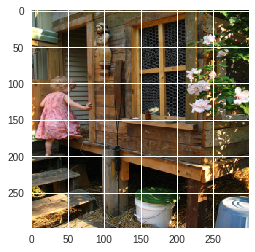

In [0]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = plt.imread('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)

In [0]:
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

with torch.no_grad():
    print(img.shape)
    img_tensor = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0)
    print(img_tensor.shape)
    _, _, logits = inception_model(img_tensor)
    print(logits.shape)
    _, top_classes = logits.topk(5)

    print('; '.join(labels[ind.item()] for ind in top_classes.squeeze()))

(299, 299, 3)
torch.Size([1, 3, 299, 299])
torch.Size([1, 1000])
rain barrel; china cabinet, china closet; patio, terrace; window screen; sliding door


Она выдает такие классы.

Подписи же к картинке такие:

In [0]:
with open('texts.txt') as f:
    text = f.readline().strip().split('\t')
print('\n'.join(text))

a child in a pink dress is climbing up a set of stairs in an entry way .
a girl going into a wooden building .
a little girl climbing into a wooden playhouse .
a little girl climbing the stairs to her playhouse .
a little girl in a pink dress going into a wooden cabin .


Загрузим данные:

In [0]:
source_field = Field(sequential=False, use_vocab=False, dtype=torch.float)
target_field = Field(init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
path_field = Field(sequential=False, use_vocab=True)

fields = [('source', source_field), ('target', target_field), ('path', path_field)]

In [0]:
img_vectors = np.load('image_codes.npy')

examples = []
with open('texts.txt') as f_texts, open('sources.txt') as f_sources:
    for img, texts, source in zip(img_vectors, f_texts, f_sources):
        for text in texts.split('\t'):
            examples.append(Example.fromlist([img, target_field.preprocess(text), source.rstrip()], fields))

In [0]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

Train size = 41264
Test size = 7282
Target vocab size = 3786


In [0]:
import random
import math

def make_batches_iter(examples, batch_size):
    class Batch:
        def __init__(self, batches_count):
            self.source = []
            self.target = []
            self.path = []
            self.batches_count = batches_count
            
    batchs_count = int(math.ceil(len(examples) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    pad_idx = target_field.vocab.stoi['<pad>']
    
    indices = np.arange(len(examples))
    np.random.shuffle(indices)

    for i in range(batchs_count):
        batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(examples))
        batch_indices = indices[batch_begin: batch_end]
        
        batch = Batch(batchs_count)

        for data_ind in batch_indices:
            batch.source.append(examples[data_ind].source)
            target = [*target_field.process([examples[data_ind].target]).view(-1).numpy()]
            batch.target.append(target)
            batch.path.append(examples[data_ind].path)

        batch.source = FloatTensor(batch.source)
        max_target_len = max(map(len, batch.target))
        batch.target = [sent + [pad_idx] * (max_target_len - len(sent)) for sent in batch.target]
        batch.target = LongTensor(batch.target).permute(1, 0)
        yield batch

In [0]:
train_iter = make_batches_iter(train_dataset.examples, 32)
batch = next(iter(train_iter))
batch.source.shape, batch.target.shape

Initializing batchs generator with 1290 batchs per epoch


(torch.Size([32, 2048]), torch.Size([21, 32]))

**Задание** Реализуйте декодер для модели:

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, cnn_feature_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._cnn_to_h0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._cnn_to_c0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, encoder_output, inputs, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(encoder_output)
        embs = self._emb(inputs)
        outputs, hidden = self._rnn(embs, hidden)
        return self._out(outputs), hidden
    
    def init_hidden(self, encoder_output):
        encoder_output = encoder_output.unsqueeze(0)
        return self._cnn_to_h0(encoder_output), self._cnn_to_c0(encoder_output)

In [0]:
model = Decoder(vocab_size=len(target_field.vocab), cnn_feature_size=img_vectors.shape[1]).to(DEVICE)
model(batch.source, batch.target)[0].shape

torch.Size([21, 32, 3786])

Хак, чтобы все работало со старым циклом обучения:

In [0]:
def evaluate_model(model, iterator):
    return 0.

In [0]:
train_iter = [*make_batches_iter(train_dataset.examples, 32)]
test_iter = [*make_batches_iter(test_dataset.examples, 256)]

Initializing batchs generator with 1290 batchs per epoch
Initializing batchs generator with 29 batchs per epoch


In [0]:
model = Decoder(vocab_size=len(target_field.vocab), cnn_feature_size=img_vectors.shape[1]).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())
fit(model, criterion, optimizer, 
    train_iter, 
    epochs_count=7, 
    val_iter=test_iter,
)

[2 / 8] Train: Loss = 3.19598, PPX = 24.43:   1%|          | 9/1290 [00:00<00:25, 49.80it/s]


Val BLEU = 0.00


[3 / 8] Train: Loss = 2.93533, PPX = 18.83:   1%|          | 9/1290 [00:00<00:26, 48.51it/s]


Val BLEU = 0.00


[4 / 8] Train: Loss = 2.76333, PPX = 15.85:   1%|          | 9/1290 [00:00<00:25, 49.60it/s]


Val BLEU = 0.00


[5 / 8] Train: Loss = 2.62173, PPX = 13.76:   1%|          | 9/1290 [00:00<00:27, 47.42it/s]


Val BLEU = 0.00


[6 / 8] Train: Loss = 2.48817, PPX = 12.04:   1%|          | 9/1290 [00:00<00:26, 48.34it/s]


Val BLEU = 0.00


[7 / 8] Train: Loss = 2.38154, PPX = 10.82:   1%|          | 9/1290 [00:00<00:26, 48.20it/s]


Val BLEU = 0.00


[8 / 8] Train: Loss = 2.29902, PPX = 9.96:   1%|          | 9/1290 [00:00<00:27, 46.91it/s]


Val BLEU = 0.00


[8 / 8]   Val: Loss = 2.65164, PPX = 14.18: 100%|██████████| 29/29 [00:00<00:00, 42.38it/s]


Val BLEU = 0.00


Проверим, что работает генерация:

**Задание** Напишите цикл генерации из модели:

In [0]:
def beam_search_decode(model, source_vector, target_field, beam_size=5):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        beams = [([bos_index], 0, source_vector)]  # tokens, score summary, hidden
        
        ready_beams = []
        for i in range(30):
            beams_continuations = []

            # 1. make next step from each beam
            for beam in beams:
                tokens, score, hidden = beam
                inputs = LongTensor([[tokens[-1]]])
                if i == 0:
                    output, hidden = model(hidden, inputs)
                else:
                    output, hidden = model(hidden, inputs, hidden)
                maxs, argmaxs = output.sort(-1, descending=True)

                for i in range(2):
                    token = argmaxs.view(-1, argmaxs.shape[-1])[:, i]
                    prob = maxs.view(-1, maxs.shape[-1])[:, i]
                    token, prob = token.view(argmaxs.shape[:-1], 1), prob.view(maxs.shape[:-1], 1)
                    score += F.log_softmax(prob)
                    beams_continuations.append( (tokens + [token], score, hidden) )

            # 2. create new beams from top beam_size of each continuation (best next token variants for the given token)
            beams = beams_continuations

            # 3. leave only top beam_size beams
            beams = sorted( beams, key=lambda beam: -beam[1] / len(beam[0]) )[:beam_size]
            # 4. repeat
            for beam in beams:
                if beam[0][-1] == eos_index:
                    ready_beams.append(beam)
            if len(ready_beams) >= len(beams):
                break
                
        beams += ready_beams
        
        result = max( beams, key=lambda beam: -beam[1] / len(beam[0]) )[0]
        return ' '.join(target_field.vocab.itos[ind] for ind in result)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


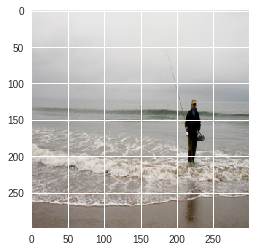

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


<s> a man is standing on a surfboard on a lake . </s>


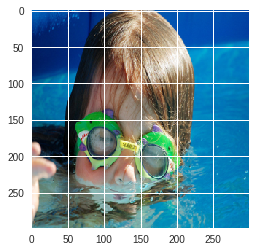

<s> a young girl is swimming underwater in a pool . </s>


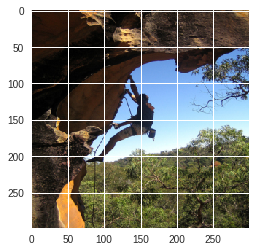

<s> a man climbs a rock wall . </s>


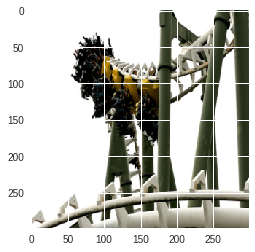

<s> a man is standing on a <unk> in front of a white building . </s> </s>


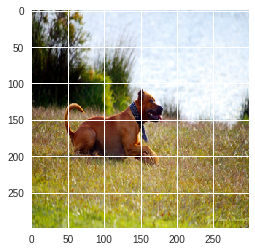

<s> a brown dog is running through a grassy area . </s>


In [0]:
batch = next(iter(test_iter))
%pylab inline 
for i in range(5):
    img = batch.path[i]

    img = plt.imread('Flicker8k_Dataset/' + img)
    img = imresize(img, (299, 299)).astype('float32') / 255.
    plt.imshow(img)
    plt.show()
    print(beam_search_decode(model, batch.source[i].unsqueeze(0), target_field))

# Дополнительные материалы

## Статьи
Sequence to Sequence Learning with Neural Networks, Ilya Sutskever, et al, 2014 [[pdf]](https://arxiv.org/pdf/1409.3215.pdf)  
Show and Tell: A Neural Image Caption Generator, Oriol Vinyals et al, 2014 [[arxiv]](https://arxiv.org/abs/1411.4555)  
Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks, Samy Bengio, et al, 2015 [[arxiv]](https://arxiv.org/abs/1506.03099)  
Neural Machine Translation of Rare Words with Subword Units, Rico Sennrich, 2015 [[arxiv]](https://arxiv.org/abs/1508.07909)  
Massive Exploration of Neural Machine Translation Architectures, Denny Britz, et al, 2017 [[pdf]](https://arxiv.org/pdf/1703.03906.pdf)

## Блоги
Neural Machine Translation (seq2seq) Tutorial [tensorflow/nmt](https://github.com/tensorflow/nmt)  
[A Word of Caution on Scheduled Sampling for Training RNNs](https://www.inference.vc/scheduled-sampling-for-rnns-scoring-rule-interpretation/)

## Видео
cs224n, [Machine Translation, Seq2Seq and Attention](https://www.youtube.com/watch?v=IxQtK2SjWWM)

## Разное
[The Annotated Encoder Decoder](https://bastings.github.io/annotated_encoder_decoder/)  
[Seq2Seq-Vis: A Visual Debugging Tool for Sequence-to-Sequence Models](http://seq2seq-vis.io)

# Сдача

[Форма для сдачи](https://goo.gl/forms/ASLLjYncKUcIHmuO2)  
[Feedback](https://goo.gl/forms/9aizSzOUrx7EvGlG3)